<a href="https://colab.research.google.com/github/jcandane/StochasticPhysics/blob/main/Mezzadri2006_fft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

based on paper https://arxiv.org/pdf/math-ph/0609050.pdf

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import plotly.graph_objects as go

π = np.pi

def get_histogram(x, data, normalize=False):
    ### binary-search of sorted data for-all domains.
    ### let: N = len(data), then: O ~ (N + len(x))log(N)
    out = np.searchsorted( np.sort(data), x, side="right")
    if normalize:
        return x[1:] + (x[:-1] - x[1:])/2, (out[1:] - out[:-1])/len(data)
    return x[1:] + (x[:-1] - x[1:])/2, out[1:] - out[:-1]

In [ ]:
def wrong_distribution(n):
    """
    """
    Z   = (np.random.randn(n,n) + 1j*np.random.randn(n,n))/np.sqrt(2)
    Q,R = np.linalg.qr(Z)
    return Q

def wrong_distributionX(n, m=1):
    """
    """
    Z   = (np.random.randn(m, n, n) + 1j*np.random.randn(m, n, n))/np.sqrt(2)
    Q,R = np.linalg.qr(Z)
    return Q

In [ ]:
N    = 50 ### in U(N)
e, v = np.linalg.eig( wrong_distributionX(N, m=10000) )

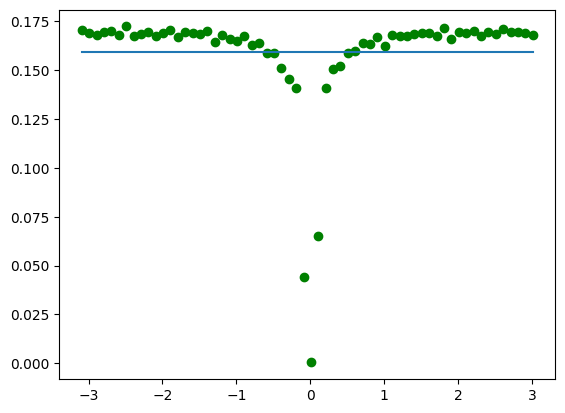

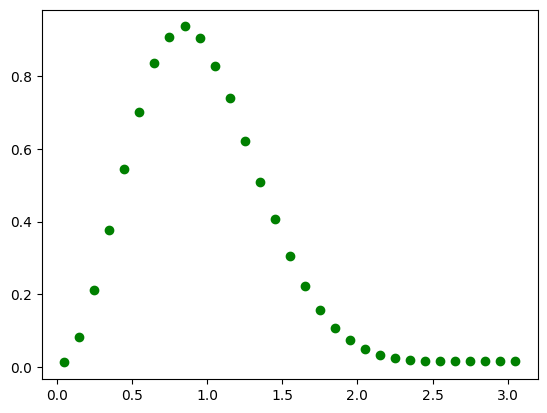

In [ ]:
dθ = 0.1

############### Plot Eigenvalue Density
bins, data = get_histogram(np.arange(-π,π, dθ), np.angle(e.reshape(-1)) )


plt.plot( bins , np.ones(len(bins))/(2*π) )
plt.scatter(  bins , data/e.size/dθ, label="A data", color="g")
plt.show()

############### Plot Eigenvalue Spacing
esorted    = np.sort( np.angle( e ) )
s          = ( N/(2*π) * ( esorted[:,1:] - esorted[:,:-1] ) )
bins, data = get_histogram(np.arange(0,π, dθ), s.reshape(-1) )


###!! plt.plot( bins , np.ones(len(bins))/(2*π) ) to get correct curve refer to Mehta 2004 Random Matrices page118, also look at https://arxiv.org/pdf/1510.04430.pdf
plt.scatter(  bins , data/e.size/dθ, label="A data", color="g")
plt.show()

## Haar

In [ ]:
def Haar_(n, m=1):
    """
    """
    Z   = (np.random.randn(m, n, n) + 1j*np.random.randn(m, n, n))/np.sqrt(2)
    Q,R = np.linalg.qr(Z)

    i = np.arange(n)
    d = R[:,i,i]
    ph = d/np.abs(d)
    return np.einsum("Iij, Ijk -> Iik", np.einsum("Iij, Ij -> Iij", Q, ph), Q)

In [ ]:
N    = 50 ### in U(N)
e, v = np.linalg.eig( Haar_(N, m=10000) )

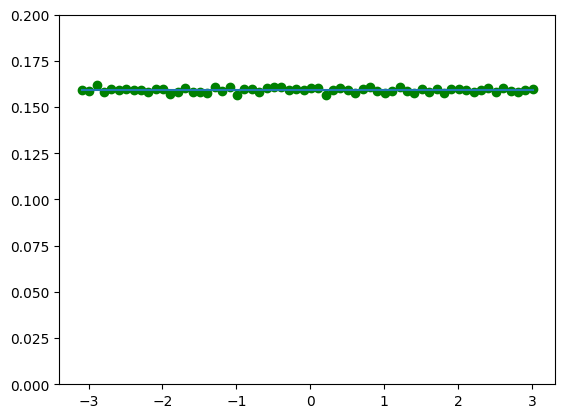

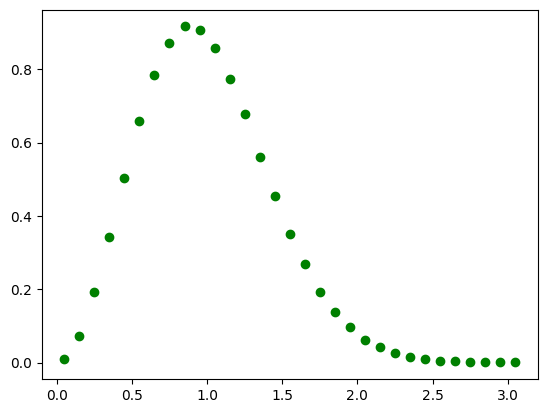

In [ ]:
dθ = 0.1

############### Plot Eigenvalue Density
bins, data = get_histogram(np.arange(-π,π, dθ), np.angle(e.reshape(-1)) )


plt.plot( bins , np.ones(len(bins))/(2*π) )
plt.scatter(  bins , data/e.size/dθ, label="A data", color="g")
plt.ylim(0,0.2)
plt.show()

############### Plot Eigenvalue Spacing
esorted    = np.sort( np.angle( e ) )
s          = ( N/(2*π) * ( esorted[:,1:] - esorted[:,:-1] ) )
bins, data = get_histogram(np.arange(0,π, dθ), s.reshape(-1) )


###!! plt.plot( bins , np.ones(len(bins))/(2*π) ) to get correct curve refer to Mehta 2004 Random Matrices page118, also look at https://arxiv.org/pdf/1510.04430.pdf
plt.scatter(  bins , data/e.size/dθ, label="A data", color="g")
plt.show()

##!!! spectrum

In [ ]:
def get_ω(time):
    dt = time[1] - time[0]
    return 2*π * np.linspace(0.0, 1.0/(2.0*dt), int(len(time)/2))

def frequency(dynamicst, dynamicsrun):
    freq        = get_ω(dynamicst)
    freqprofile = np.abs(2.0/len(dynamicst) * (np.fft.fft( dynamicsrun, axis=0 ))[:len(dynamicst)//2])
    return freq / (2*π), freqprofile

# ${\displaystyle {\frac {1}{\pi \gamma \,\left[1+\left({\frac {x-x_{0}}{\gamma }}\right)^{2}\right]}}\!}$

In [ ]:
def dressing(x0, γ=1.0, dx=0.1):
    x = np.arange(-1,1+dx, dx)
    return np.sum( 1/( π*γ * ( 1 + ( (x[:,None] - x0[None,:])/γ )**2) ), axis=1)

In [ ]:
NN     = 3 ### in U(N)
ee, vv = np.linalg.eig( Haar_(NN, m=10) )

In [ ]:
ee.shape

(10, 3)

In [ ]:
from numpy.fft import fft, ifft

N     = 100
f_max = 0.1

f = np.arange(N) * (f_max/N) ##/T
t = np.arange(N) / f_max

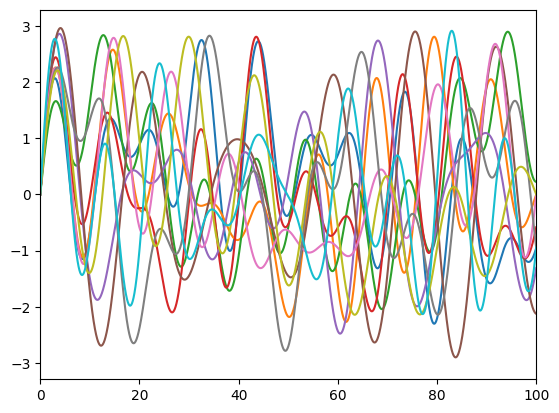

In [ ]:
ttt = np.arange(0, 100/f[-1]-0.01, 0.01)

j = (np.abs(ee.real)* N).astype(int)

plt.plot( ttt, np.sum( np.sin( np.einsum("aj, t -> ajt", 2*π*f[j], ttt) ), axis=1).T)
plt.xlim(0,100)
plt.show()

## use RCF to produce "R"MTs

In [ ]:
try:
    import GPy
except:
    !pip install gpy
    import GPy

class RCF():
    """ built: 3/19/2024
    this an object of a Random-Contionus-Function (RCF), with-respect-to a gpy kernel
    RCF : IN -> OUT = R^(MO)
    we define a prior, and then sample to form a posterior.
    """

    def __init__(self, Domain:np.ndarray, N:int, MO:int=1, seed:int=777,
                 IN_noise=None, OUT_noise=None,
                 kernel=GPy.kern.RBF):
        """ !! note datatypes should be tf.float64 for stable Cholesky-operations
        GIVEN >
             Domain : 2d-np.ndarray (with shape=(d,2), with d=# of dims )
                  N : int (number-of-defining-points)
                 MO : int (Multiple-Output Dimension)
             **seed : int
           **kernel : GPy.kern
         **IN_noise : 1d-np.ndarray (len == Domain.shape[1])
        **OUT_noise : 1d-np.ndarray (len == MO)

        GET   >
            None
        """

        self.dtype  = np.float64
        self.IN     = Domain.astype(self.dtype)  ### : np.ndarray (IN-space range)
        self.N      = N      ### number of defining points
        self.MO     = MO     ### int (dimension of OUT)
        self.kernel = kernel(self.IN.shape[0])
        self.seed   = seed ### define pseudo-random seed

        np.random.seed( self.seed )

        ### define anisotropic i.i.d white-noise
        if IN_noise is None:
            self.IN_noise=np.zeros(self.IN.shape[0], dtype=self.dtype)
        else:
            self.IN_noise = IN_noise
        if OUT_noise is None:
            self.OUT_noise=np.zeros(self.MO, dtype=self.dtype)
        else:
            self.OUT_noise = OUT_noise

        ### define IN-space defining-points
        self.R_ix  = np.random.uniform(0,1, (self.N, self.IN.shape[0])).astype(self.dtype)
        self.R_ix *= (self.IN[:,1] - self.IN[:,0])
        self.R_ix += self.IN[:,0]

        ### compute cholesky-factorization
        ### this will fail if K is not-PSD LinAlgError: Matrix is not positive definite
        try:
            L_ij = np.linalg.cholesky( self.kernel.K( self.R_ix ) ) ## not immutable
        except:
            #print("not PSD added to diag")
            L_ij = np.linalg.cholesky( self.kernel.K( self.R_ix ) + np.diag( 1.e-8 * np.random.rand(self.N).astype(self.dtype) ) )

        ### compute OUT-space defining-points
        D_iX  = np.random.normal(0,1,(self.N, self.MO)).astype(self.dtype)
        D_iX *= np.diag(L_ij)[:,None]
        D_iX  = np.matmul(L_ij, D_iX)

        self.S_iX  = scipy.linalg.cho_solve((L_ij, True), D_iX)

    def evaluate(self, D_ax):
        """ evaluate for arbitrary values/points in OUT given points in IN.
        GIVEN >
              self
              D_ax : 2d-np.ndarray (D_ax ∈ IN)
        GET   >
              D_aX : 2d-np.ndarray (D_aX ∈ OUT, note captial 'X')
        """
        D_ax += self.IN_noise*np.random.normal(0,1,D_ax.shape).astype(self.dtype)
        D_aX  = np.matmul( self.kernel.K(D_ax, self.R_ix), self.S_iX )
        D_aX += self.OUT_noise*np.random.normal(0,1,D_aX.shape).astype(self.dtype)
        return D_aX

    def get_spectra(self, D_ax):
        """
        D_ax = points you desire to get matrix of
        """
        D_aX  = np.matmul( self.kernel.K(D_ax, self.R_ix), self.S_iX )

        k = GPy.kern.RBF(1)
        e_aX, v_aXY = np.linalg.eigh( np.asarray([ k.K(D_aX[i].reshape(-1,1)) for i in range(D_aX.shape[0]) ]) )

        ################
        N     = 1000
        f_max = 0.1

        f = np.arange(N) * (f_max/N) ##/T
        t = np.arange(N) / f_max

        t = np.arange(0, 100/f[-1]-0.01, 0.01)
        j = (np.abs(e_aX.real)/(np.amax( np.abs(e_aX.real) )+f_max)* N).astype(int)

        spectra = np.zeros(N)
        spectra[j] = 1

        return t, np.sum( np.sin( np.einsum("aj, t -> ajt", 2*π*f[j], t) ), axis=1).T

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 8.5 MB/s eta 0:00:00


In [ ]:
Domain = np.array([[0,5.],[0,7.]])

f = RCF(Domain, 18, MO=3)



In [ ]:
#### generate mesh to plot
R_ax = np.stack(np.meshgrid(*[ np.linspace(Domain[i,0], Domain[i,1], 20) for i in range(len(Domain)) ]), axis=-1)
#R_ax = R_ax.reshape((tf.prod( tf.asarray(R_ax.shape[:-1]) ), R_ax.shape[-1]))
shaper = np.concatenate((np.asarray(R_ax.shape[:-1], dtype=np.int64), R_ax.shape[-1]*np.ones(1, dtype=np.int64)))
R_ax = np.reshape(R_ax, (np.prod(R_ax.shape[:-1]), R_ax.shape[-1]))

R_ay = f.evaluate(R_ax)

#### the plot
fig = go.Figure(data=[go.Scatter3d(x=R_ax[:,0], y=R_ax[:,1], z=R_ay[:,0], mode='markers'),
                      go.Scatter3d(x=f.R_ix[:,0], y=f.R_ix[:,1], z=f.evaluate(f.R_ix)[:,0], mode='markers')])
fig.show()

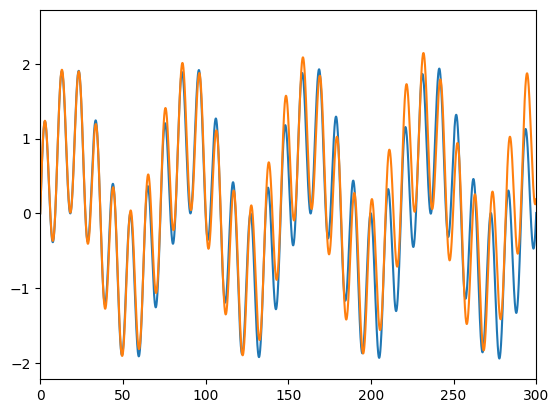

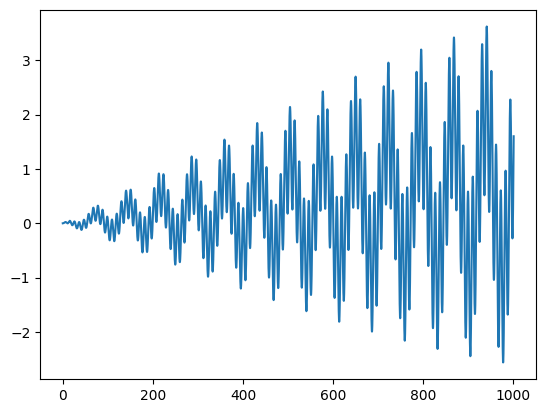

In [ ]:
points = np.array([[0.0,0.0],[0.0,0.031],[4.56,6.005],[4.56,5.955],[3.2,7.2],[3.4,5.1]])

t, A = f.get_spectra(points)

plt.plot( t, A[:,:2])
plt.xlim(0,300)
plt.show()

plt.plot( t, np.diff(A[:,0:2], axis=1))
#plt.xlim(0,1000)
plt.show()

In [ ]:


#f.get_spectra(points)
D_aX = f.evaluate(points)
D_aX.shape
e_aX, v_aXY = np.linalg.eigh( np.einsum("aX, aY -> aXY", D_aX, D_aX) )

#e_aX, v_aXY = np.linalg.eigh( np.einsum("aij, ajk -> aik", D_aX.reshape((6,2,2)), D_aX.reshape((6,2,2))) )

#e_aX[:,-1]

In [ ]:
v_aXY

array([[[ 7.08762186e-03, -9.84946942e-01,  1.72711570e-01],
        [ 6.60232693e-01,  1.34326955e-01,  7.38951325e-01],
        [-7.51027667e-01,  1.08792418e-01,  6.51246230e-01]],

       [[-9.82078221e-01, -7.40450587e-02,  1.73319640e-01],
        [ 8.04124739e-02,  6.67084474e-01,  7.40629556e-01],
        [ 1.70458800e-01, -7.41293218e-01,  6.49174986e-01]],

       [[ 9.92349657e-01, -3.97718451e-03,  1.23395056e-01],
        [ 1.22555250e-01, -8.89883699e-02, -9.88464102e-01],
        [-1.49120290e-02, -9.96024725e-01,  8.78201535e-02]],

       [[ 9.94080624e-01, -6.60468064e-04,  1.08642884e-01],
        [ 1.08466486e-01, -5.12499549e-02, -9.92778154e-01],
        [-6.22364114e-03, -9.98685639e-01,  5.08749485e-02]],

       [[-7.03223301e-01, -7.03223301e-01,  1.04661250e-01],
        [ 6.02520485e-01, -5.11316982e-01,  6.12800138e-01],
        [ 3.77420262e-01, -4.93995883e-01, -7.83276460e-01]],

       [[-9.94713377e-01,  5.41025580e-02,  8.72823626e-02],
        [ 1.02

In [ ]:
k = GPy.kern.RBF(1)
e, v = np.linalg.eigh( np.asarray([ k.K(D_aX[i].reshape(-1,1)) for i in range(6) ]) )
e

array([[2.68051501e-03, 3.73372420e-01, 2.62394707e+00],
       [3.05551666e-03, 3.81426749e-01, 2.61551773e+00],
       [1.71716357e-03, 9.48719584e-01, 2.04956325e+00],
       [4.44334412e-03, 9.40719691e-01, 2.05483697e+00],
       [5.65195948e-02, 6.54028116e-01, 2.28945229e+00],
       [1.14844395e-01, 8.32820448e-01, 2.05233516e+00]])

[[-6.89905123e-20  1.33233662e-15  2.43443818e+00]
 [-4.46628113e-16  2.53890271e-18  2.50390939e+00]
 [-4.44096288e-16 -3.46236924e-18  3.01929293e+00]
 [-4.44089406e-16 -8.67166087e-19  3.00969471e+00]
 [-2.90493324e-18  2.90493324e-18  1.04050709e+00]
 [-8.90813698e-16  2.63527880e-18  6.17350693e+00]]
[[ 0  0 38]
 [ 0  0 39]
 [ 0  0 48]
 [ 0  0 47]
 [ 0  0 16]
 [ 0  0 98]]


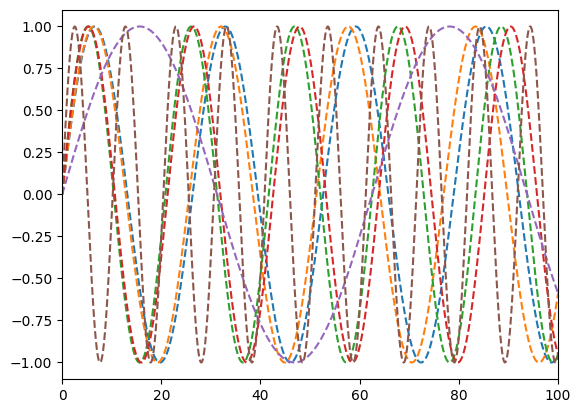

In [ ]:
################
N     = 100
f_max = 0.1

ff = np.arange(N) * (f_max/N) ##/T
t  = np.arange(N) / f_max

print(e_aX)
t = np.arange(0, 100/ff[-1]-0.01, 0.01)
j = (np.abs(e_aX.real)/(np.amax( np.abs(e_aX.real) )+f_max)   * N).astype(int) ### /10 is hardcoded!!! find solution
print(j)

plt.plot( t, np.sum( np.sin( np.einsum("aj, t -> ajt", 2*π*ff[j], t) ), axis=1).T, linestyle="dashed")
plt.xlim(0,100)
plt.show()

# March 27, SpectraLandscape

In [ ]:
class SpectraLandscape():
    """ built: 3/27/2024
    this an object of a Random-Contionus-Function (RCF), with-respect-to a gpy kernel
    RCF : IN -> OUT = R^(MO)
    we define a prior, and then sample to form a posterior.
    """

    def __init__(self, Domain:np.ndarray, N:int, MO:int=1, seed:int=777,
                 IN_noise=None, OUT_noise=None,
                 kernel=GPy.kern.RBF):
        """ !! note datatypes should be tf.float64 for stable Cholesky-operations
        GIVEN >
             Domain : 2d-np.ndarray (with shape=(d,2), with d=# of dims )
                  N : int (number-of-defining-points)
                 MO : int (Multiple-Output Dimension)
             **seed : int
           **kernel : GPy.kern
         **IN_noise : 1d-np.ndarray (len == Domain.shape[1])
        **OUT_noise : 1d-np.ndarray (len == MO)

        GET   >
            None
        """

        self.dtype  = np.float64
        self.IN     = Domain.astype(self.dtype)  ### : np.ndarray (IN-space range)
        self.N      = N      ### number of defining points
        self.MO     = MO     ### int (dimension of OUT)
        self.kernel = kernel(self.IN.shape[0])
        self.seed   = seed ### define pseudo-random seed

        np.random.seed( self.seed )

        ### define anisotropic i.i.d white-noise
        if IN_noise is None:
            self.IN_noise=np.zeros(self.IN.shape[0], dtype=self.dtype)
        else:
            self.IN_noise = IN_noise
        if OUT_noise is None:
            self.OUT_noise=np.zeros(self.MO, dtype=self.dtype)
        else:
            self.OUT_noise = OUT_noise

        ### define IN-space defining-points
        self.R_ix  = np.random.uniform(0,1, (self.N, self.IN.shape[0])).astype(self.dtype)
        self.R_ix *= (self.IN[:,1] - self.IN[:,0])
        self.R_ix += self.IN[:,0]

        ### compute cholesky-factorization
        ### this will fail if K is not-PSD LinAlgError: Matrix is not positive definite
        try:
            L_ij = np.linalg.cholesky( self.kernel.K( self.R_ix ) ) ## not immutable
        except:
            #print("not PSD added to diag")
            L_ij = np.linalg.cholesky( self.kernel.K( self.R_ix ) + np.diag( 1.e-8 * np.random.rand(self.N).astype(self.dtype) ) )

        ### compute OUT-space defining-points
        D_iX  = np.random.normal(0,1,(self.N, self.MO)).astype(self.dtype)
        D_iX *= np.diag(L_ij)[:,None]
        D_iX  = np.matmul(L_ij, D_iX)

        self.S_iX  = scipy.linalg.cho_solve((L_ij, True), D_iX)

    def evaluate(self, D_ax):
        """ evaluate for arbitrary values/points in OUT given points in IN.
        GIVEN >
              self
              D_ax : 2d-np.ndarray (D_ax ∈ IN)
        GET   >
              D_aX : 2d-np.ndarray (D_aX ∈ OUT, note captial 'X')
        """
        D_ax += self.IN_noise*np.random.normal(0,1,D_ax.shape).astype(self.dtype)
        D_aX  = np.matmul( self.kernel.K(D_ax, self.R_ix), self.S_iX )
        D_aX += self.OUT_noise*np.random.normal(0,1,D_aX.shape).astype(self.dtype)
        return D_aX

    def get_spectra(self, D_ax):
        """
        D_ax = points you desire to get matrix of
        """
        D_aX  = np.matmul( self.kernel.K(D_ax, self.R_ix), self.S_iX )

        k = GPy.kern.RBF(1)
        e_aX, v_aXY = np.linalg.eigh( np.asarray([ k.K(D_aX[i].reshape(-1,1)) for i in range(D_aX.shape[0]) ]) )

        ################
        N     = 1000
        f_min = 0.0
        f_max = 0.1
        fs    = np.linspace(f_min, f_max, N)

        f = np.arange(N) * (f_max/N) ##/T
        t = np.arange(N) / f_max

        #t = np.arange(0, 100/f[-1]-0.01, 0.01)
        j = (np.abs(e_aX.real)/(np.amax( np.abs(e_aX.real) )+f_max)* N).astype(int)

        print(j)
        spectra = np.zeros((D_aX.shape[0],N))

        for i in range(D_aX.shape[0]):
            spectra[i, j[i]] = np.abs( v_aXY[i,0] )**2

        return fs, spectra #np.sum( np.sin( np.einsum("aj, t -> ajt", 2*π*f[j], t) ), axis=1).T

In [ ]:
Domain = np.array([[0,5.],[0,7.]])

f = SpectraLandscape(Domain, 21, MO=3)

############
#### generate mesh to plot
R_ax = np.stack(np.meshgrid(*[ np.linspace(Domain[i,0], Domain[i,1], 20) for i in range(len(Domain)) ]), axis=-1)
#R_ax = R_ax.reshape((tf.prod( tf.asarray(R_ax.shape[:-1]) ), R_ax.shape[-1]))
shaper = np.concatenate((np.asarray(R_ax.shape[:-1], dtype=np.int64), R_ax.shape[-1]*np.ones(1, dtype=np.int64)))
R_ax = np.reshape(R_ax, (np.prod(R_ax.shape[:-1]), R_ax.shape[-1]))

R_ay = f.evaluate(R_ax)

#### the plot
fig = go.Figure(data=[go.Scatter3d(x=R_ax[:,0], y=R_ax[:,1], z=R_ay[:,0], mode='markers'),
                      go.Scatter3d(x=f.R_ix[:,0], y=f.R_ix[:,1], z=f.evaluate(f.R_ix)[:,0], mode='markers')])
fig.show()

[[  0  37 933]
 [  0  38 933]
 [ 31 286 654]
 [ 30 287 654]
 [  0   4 967]
 [  0  61 910]]


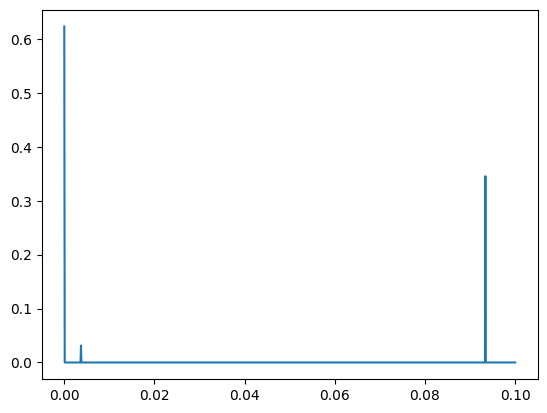

In [ ]:
points = np.array([[0.0,0.0],[0.0,0.01],[4.56,6.005],[4.56,5.955],[3.2,7.2],[3.4,5.1]])

t, A = f.get_spectra(points)

plt.plot( t, A.T[:,0])
plt.show()

In [ ]:
np.abs( 1 + 1.j )**2

2.0000000000000004

# New work (4/2/2024)

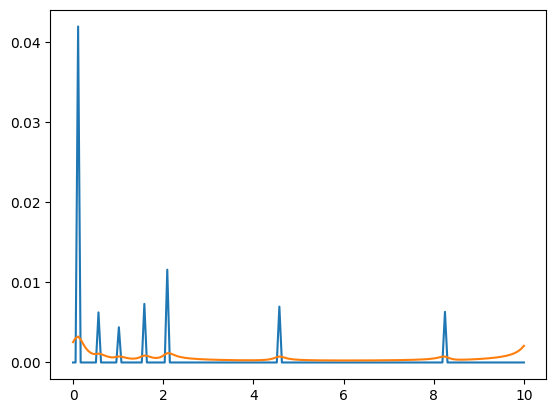

True


In [114]:
domain = np.array([[0,10.],[0,11.]])
N      = 19  ## number of defining points
l      = 9   ## number of features
d      = 178 ## number of pixels
d_min  = 0.
d_max  = 10.
γ      = 0.8


##################
MO     = l*(l+1)//2

###### create: random-Matrix à la Wigner
M       = np.zeros((l, l), dtype=int)
i, j    = np.triu_indices(l, k=0)
M[i, j] = np.arange(MO) ## wrap this into a symmetric matrix
M[j, i] = np.arange(MO)
######

E_i, v_ij = np.linalg.eigh(M) ### sorted eigenvalues
v_i       = v_ij[:,0] ### these transitions 0->n,  will yield amplitude

detector_f = np.linspace(d_min, d_max, d)  ### detector frequency bins
detector_A = np.zeros( d ) ### detector

### now each E_i correspond for an index, enumerating the location of the detector
### a histogram!! we need the spacing df, divide int( E/df ) to get the detector pixel it belongs to!

df = (d_max-d_min)/d ## frequnecy resolution of the detector
Ei = ((E_i-d_min)/df).astype(int)

vi = v_i[ 0 < Ei ]
Ei = Ei[ 0 < Ei ] ### only pixels within the detector
vi = vi[ d > Ei ]
Ei = Ei[ d > Ei ] ### only pixels within the detector

detector_A[Ei] = np.abs(vi)**2 ### IDEAL (stick-figure) detector intensities
t              = np.arange(d) / (d_max-d_min)
OUT            = np.abs( np.fft.ifft( np.fft.fft( detector_A )*np.exp(-γ*t) ) )
##################


plt.plot(detector_f, detector_A)
plt.plot(detector_f, OUT )
plt.show()



print( np.allclose( np.fft.ifft( np.fft.fft( detector_A ) ), detector_A ) ) #

In [123]:
R_ix = np.random.rand(N,MO)

In [152]:
###### create: random-Matrix à la Wigner
M       = np.zeros((N, l, l), dtype=float)
i, j    = np.triu_indices(l, k=0)
for n in range(N):
    M[n, i, j] = R_ix[n] ## wrap this into a symmetric matrix
    M[n, j, i] = R_ix[n]
M[5]

E_nl, v_nij = np.linalg.eigh(M)
A_nl = v_nij[:,:,0]

E_nl ## if < d_min
E_nl[E_nl < 0] = 0
A_nl[E_nl < 0] = 0.
E_nl

array([[0.        , 0.        , 0.        , 0.01252012, 0.08839064,
        0.17591922, 0.80169288, 1.39783474, 5.18079153],
       [0.        , 0.        , 0.        , 0.        , 0.19483946,
        0.44323071, 0.58742076, 1.34510404, 4.40947907],
       [0.        , 0.        , 0.        , 0.        , 0.21046357,
        0.24902922, 0.78193397, 1.14092174, 4.16292092],
       [0.        , 0.        , 0.        , 0.        , 0.24904001,
        0.45303989, 0.85993819, 1.16206372, 5.07704937],
       [0.        , 0.        , 0.        , 0.        , 0.03160768,
        0.62319876, 0.8086955 , 1.64963012, 5.09241586],
       [0.        , 0.        , 0.        , 0.22314534, 0.32540143,
        0.6285841 , 0.80441171, 1.2521078 , 4.26630557],
       [0.        , 0.        , 0.        , 0.        , 0.17556688,
        0.40999367, 0.82752369, 1.13373319, 4.39455216],
       [0.        , 0.        , 0.        , 0.1117832 , 0.45837954,
        0.80532923, 0.9455457 , 1.21041085, 4.76211484],


In [126]:
M[0,1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0])

In [247]:
def construct_Wigner(R_ix):
    ###### create: random-Matrix à la Wigner
    l       = int( 0.5*(np.sqrt(8*R_ix.shape[1]+1)-1) )
    M       = np.zeros((R_ix.shape[0], l, l), dtype=R_ix.dtype)
    i, j    = np.triu_indices(l, k=0)
    for n in range(R_ix.shape[0]):
        M[n, i, j] = R_ix[n] ## wrap this into a symmetric matrix
        M[n, j, i] = R_ix[n]
    return M

class SpectraLandscape():
    """ built: 3/27/2024
    this an object of a Random-Contionus-Function (RCF), with-respect-to a gpy kernel
    RCF : IN -> OUT = R^(d)
    we define a prior, and then sample to form a posterior.
    """

    def __init__(self, Domain:np.ndarray, N:int, d:int=100, seed:int=777,
                 l:int=10, d_min:np.float64=0, d_max:np.float64=1., γ:np.float64=0.0,
                 IN_noise=None, OUT_noise=None,
                 kernel=GPy.kern.RBF):
        """ !! note datatypes should be tf.float64 for stable Cholesky-operations
        GIVEN >
             Domain : 2d-np.ndarray (with shape=(d,2), with d=# of dims )
                  N : int (number-of-defining-points)
                 d : int (Multiple-Output Dimension)
             **seed : int
           **kernel : GPy.kern
         **IN_noise : 1d-np.ndarray (len == Domain.shape[1])
        **OUT_noise : 1d-np.ndarray (len == d)

        GET   >
            None
        """

        self.dtype  = np.float64
        self.IN     = Domain.astype(self.dtype)  ### : np.ndarray (IN-space range)
        self.N      = N      ### number of defining points
        self.d      = d     ### int (dimension of OUT)
        self.l      = l    ### : inter (features in the spectra)
        self.kernel = kernel(self.IN.shape[0])
        self.seed   = seed ### define pseudo-random seed
        self.d_min  = d_min
        self.d_max  = d_max
        self.γ      = γ

        self.MO     = self.l*(self.l+1)//2

        np.random.seed( self.seed )

        ### define anisotropic i.i.d white-noise
        if IN_noise is None:
            self.IN_noise=np.zeros(self.IN.shape[0], dtype=self.dtype)
        else:
            self.IN_noise = IN_noise
        if OUT_noise is None:
            self.OUT_noise=np.zeros(self.MO, dtype=self.dtype)
        else:
            self.OUT_noise = OUT_noise

        ### define IN-space defining-points
        self.R_ix  = np.random.uniform(0,1, (self.N, self.IN.shape[0])).astype(self.dtype)
        self.R_ix *= (self.IN[:,1] - self.IN[:,0])
        self.R_ix += self.IN[:,0]

        ### compute cholesky-factorization
        ### this will fail if K is not-PSD LinAlgError: Matrix is not positive definite
        try:
            L_ij = np.linalg.cholesky( self.kernel.K( self.R_ix ) ) ## not immutable
        except:
            #print("not PSD added to diag")
            L_ij = np.linalg.cholesky( self.kernel.K( self.R_ix ) + np.diag( 1.e-8 * np.random.rand(self.N).astype(self.dtype) ) )

        ### compute OUT-space defining-points
        D_iX  = np.random.normal(0,1,(self.N, self.MO)).astype(self.dtype)
        D_iX *= np.diag(L_ij)[:,None]
        D_iX  = np.matmul(L_ij, D_iX)

        self.S_iX  = scipy.linalg.cho_solve((L_ij, True), D_iX)

    def evaluate(self, D_ax):
        """ evaluate for arbitrary values/points in OUT given points in IN.
        GIVEN >
              self
              D_ax : 2d-np.ndarray (D_ax ∈ IN)
        GET   >
              D_aX : 2d-np.ndarray (D_aX ∈ OUT, note captial 'X')
        """
        D_ax += self.IN_noise*np.random.normal(0,1,D_ax.shape).astype(self.dtype)
        D_aX  = np.matmul( self.kernel.K(D_ax, self.R_ix), self.S_iX )
        D_aX += self.OUT_noise*np.random.normal(0,1,D_aX.shape).astype(self.dtype)
        return D_aX

    def get_freq(self):
        return np.linspace(self.d_min, self.d_max, self.d)

    def __call__(self, D_ax):

        df = (self.d_max-self.d_min)/self.d ## :float,  frequnecy resolution of the detector


        D_aX = self.evaluate(D_ax)
        M    = construct_Wigner(D_aX)
        E_ni, v_nij = np.linalg.eigh(M)
        A_nl = v_nij[:,:,0]

        E_ni = ((E_ni-self.d_min)/df).astype(int)
        mask = np.logical_or( (E_ni < 0) , (E_ni > self.d-1) )
        E_ni[mask] = 0
        A_nl[mask] = 0.

        detector_f = np.ones(D_ax.shape[0])[:,None]*np.linspace(self.d_min, self.d_max, self.d)[None,:]  ### detector frequency bins
        detector_A = np.ones(D_ax.shape[0])[:,None]*np.zeros( self.d )[None,:]  ### detector

        ###?
        for n in range(D_ax.shape[0]):
            detector_A[n,E_ni[n,:]] = np.abs(A_nl[n,:])**2 ### IDEAL (stick-figure) detector intensities
        #detector_A[:,E_ni[:]] = np.abs(A_nl[:])**2
        t   = np.arange(self.d) / (self.d_max-self.d_min)
        OUT = np.abs( np.fft.ifft( np.fft.fft( detector_A , axis=1)*np.exp(-self.γ*t)[None,:] , axis=1 ) )
        return OUT

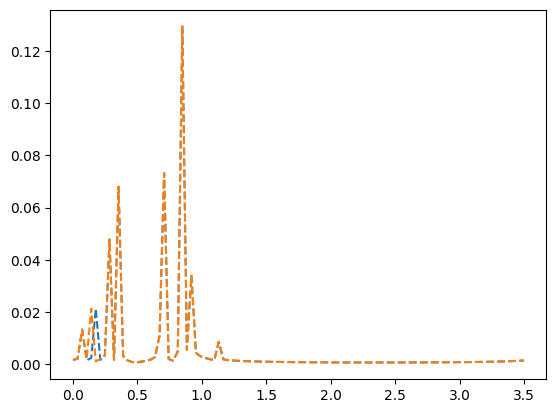

In [256]:
domain = np.array([[0,10.],[0,11.]])

f = SpectraLandscape(domain, 19, γ=0.01, l=20, d_max=3.5)

As = f( np.array([[0.205,10.],[0.2,10.],[4.5,8.4]]) ) #,[0.68,7.5]]) )
As = f( np.array([[0.205,10.],[0.2,10.]]) )
#As = f( np.array([[0.25,10.] ]) )

plt.plot(f.get_freq(), As.T, linestyle="dashed")
plt.show()